# Scrape a data set describing the most popular Halloween sweets

dataset: https://www.kaggle.com/datasets/fivethirtyeight/the-ultimate-halloween-candy-power-ranking/data

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as st
%matplotlib inline

In [83]:
# Let's read in the data
data = pd.read_csv('candy-data.csv')

In [3]:
# What do the first few rows look like?
data.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


In [4]:
#How many entries do we have?
data.shape

(85, 13)

In [5]:
# How many entries are missing?
data.isna().sum()

competitorname      0
chocolate           0
fruity              0
caramel             0
peanutyalmondy      0
nougat              0
crispedricewafer    0
hard                0
bar                 0
pluribus            0
sugarpercent        0
pricepercent        0
winpercent          0
dtype: int64

In [6]:
# What data types are the different columns?
data.dtypes

competitorname       object
chocolate             int64
fruity                int64
caramel               int64
peanutyalmondy        int64
nougat                int64
crispedricewafer      int64
hard                  int64
bar                   int64
pluribus              int64
sugarpercent        float64
pricepercent        float64
winpercent          float64
dtype: object

In [78]:
# Let's plot them in order of winning
data = data.sort_values('winpercent', ascending=False)

In [8]:
# Ok how might we want to plot this?

<Axes: xlabel='competitorname'>

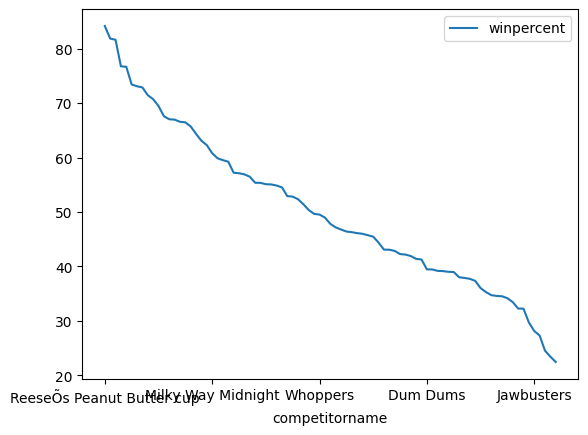

In [9]:
data.plot('competitorname','winpercent')

<Axes: xlabel='chocolate'>

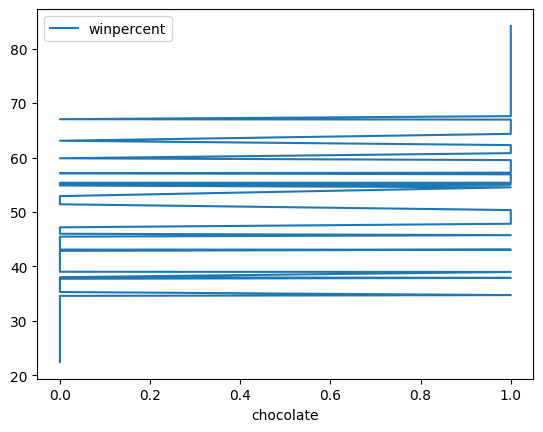

In [10]:
data.plot('chocolate','winpercent')

In [11]:
# Want to ask what were the biggest factors in determining what someone's favourite was

In [85]:
# do a t-test 
st.ttest_ind(data.fruity, data.chocolate)

TtestResult(statistic=0.15356515607031287, pvalue=0.8781369162671906, df=168.0)

In [87]:
r = np.corrcoef(data.sugarpercent, data.winpercent)
r

array([[1.        , 0.22915066],
       [0.22915066, 1.        ]])

In [14]:
#what about if it is fruity AND chocolate-y?
# does price point matter? if it's trick-or-treating, then you're not paying either way?

In [15]:
# Random generate some candy and predict how often it would win?

In [16]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=data.pricepercent.min(), vmax=data.pricepercent.max())

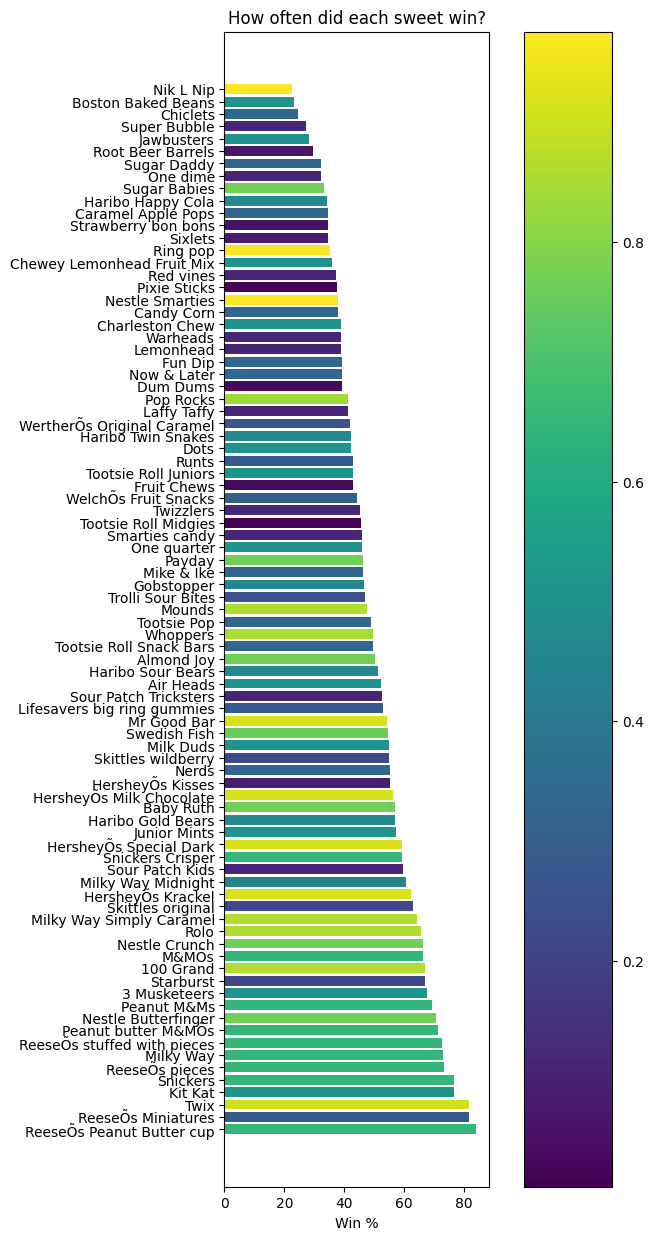

In [79]:
fig, axes = plt.subplots(1,2, figsize=(5,15), gridspec_kw={'width_ratios': [3, 1]})
ax, cax = axes[0], axes[1]
ax.barh(data.competitorname, data.winpercent, color=cmap(norm(data.pricepercent)))
# im = ax.barh(data.competitorname, data.winpercent, color=cmap(norm(data.sugarpercent)))
ax.set_xlabel('Win %')
ax.set_title('How often did each sweet win?')
ax.grid(False)
# ax.set_ylim(-1, 85)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='vertical')
plt.show()

In [76]:
## about 2 hours so far on this, brainstorming and working on this ipynb file

In [19]:
# next, run idea by pratik, and decide whether to do r analysis or not

In [20]:
# Useful links
# https://en.wikipedia.org/wiki/Halloween_Problem
# http://publish.illinois.edu/commonsknowledge/2021/10/29/halloween-data-visualizations/
# https://frightgeist.withgoogle.com/costumes#top-costumes
# https://towardsdatascience.com/data-visualizations-with-a-halloween-candy-dataset-b6361d5d29f8
# https://fivethirtyeight.com/videos/the-ultimate-halloween-candy-power-ranking/
# https://realpython.com/numpy-scipy-pandas-correlation-python/
# https://www.kaggle.com/datasets/fivethirtyeight/the-ultimate-halloween-candy-power-ranking/


## Now picking this back up in 6/1/24
Let's make a radar chart with this data, to visualize how different sweet characteristics influence their rating

In [23]:
data.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782


In [54]:
data.winpercent = data.winpercent/100

In [81]:
data = data[data.chocolate==1]

In [25]:
import plotly.graph_objects as go
import plotly.offline as pyo

In [46]:
aspects = data.columns[-3:]

In [62]:
fig = go.Figure(
    data = [
        go.Scatterpolar(r=data.iloc[i][-3:], theta=aspects, name=data.iloc[i][0], fill='toself') for i in range(data.shape[0])]
    )

In [63]:
pyo.plot(fig)

'temp-plot.html'

In [52]:
data.iloc[52][-3:]

sugarpercent        0.127
pricepercent        0.034
winpercent      43.088924
Name: 15, dtype: object

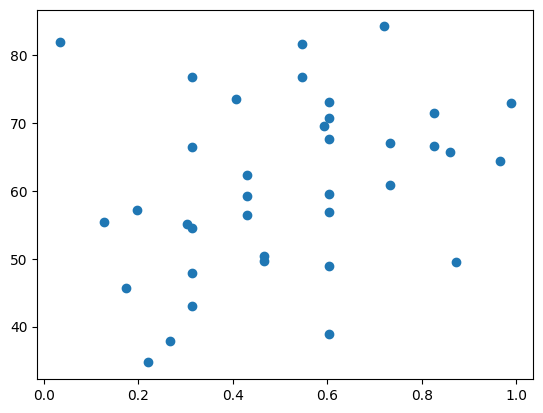

In [82]:
plt.scatter(data.sugarpercent, data.winpercent)